In [19]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
import math
import warnings
import time

# Ignore PerformanceWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [20]:
# 读取数据
df1 = pd.read_csv('data/smci_sorted.csv')

In [21]:
# Custom input variables
features = ['DPRIME', 'Close', 'Volume', 'Open', 'High', 'Low']
target = 'Close'

# Data normalization
min_max_scaler = preprocessing.MinMaxScaler()
df0 = min_max_scaler.fit_transform(df1[features])  # Normalize only the selected features
df = pd.DataFrame(df0, columns=features)

# Create lag features
def create_lag_features(data, features, lag=90):
    lagged_data = pd.DataFrame(index=data.index)
    for feature in features:
        for i in range(1, lag + 1):
            lagged_data[f'{feature}_lag_{i}'] = data[feature].shift(i)
    return pd.concat([data, lagged_data], axis=1)

# Generate lag features
data_lagged = create_lag_features(df, features, lag=90)
data_lagged = data_lagged.dropna()  # Remove rows with missing values

# Define features and target variables
X = data_lagged.drop(columns=[target])
y = data_lagged[target]

# Standardize the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sliding window prediction settings
window_size = 90  # Sliding window size
test_size = 10    # Predict 10 days each time
predictions = []
actuals = []

In [22]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(f'Shape of X_scaled: {X_scaled.shape}')

Shape of X: (2426, 545)
Shape of y: (2426,)
Shape of X_scaled: (2426, 545)


In [23]:
# GBDT training module
start_time = time.time()
for i in range(window_size, len(X_scaled) - test_size + 1, test_size):
    X_train = X_scaled[i - window_size:i]
    y_train = y.values[i - window_size:i]
    X_test = X_scaled[i:i + test_size]
    y_test = y.values[i:i + test_size]
    
    # Train GBDT model
    gbdt = GradientBoostingRegressor()
    model = gbdt.fit(X_train, y_train)
    
    # Predict on the test set
    y_test_predict = model.predict(X_test)
    predictions.extend(y_test_predict)
    actuals.extend(y_test)

# Record end time and print elapsed time
end_time = time.time()
print('GBDT运行时间（秒）:', end_time - start_time)

GBDT运行时间（秒）: 1246.6712024211884


In [25]:
# 评估模型性能
predictions = np.array(predictions)
actuals = np.array(actuals)

In [26]:
# 检查 predictions 和 actuals 的类型
print(f'Type of predictions: {type(predictions)}')
print(f'Type of actuals: {type(actuals)}')
print(f'Shape of predictions: {predictions.shape}')
print(f'Shape of actuals: {actuals.shape}')

Type of predictions: <class 'numpy.ndarray'>
Type of actuals: <class 'numpy.ndarray'>
Shape of predictions: (2330,)
Shape of actuals: (2330,)


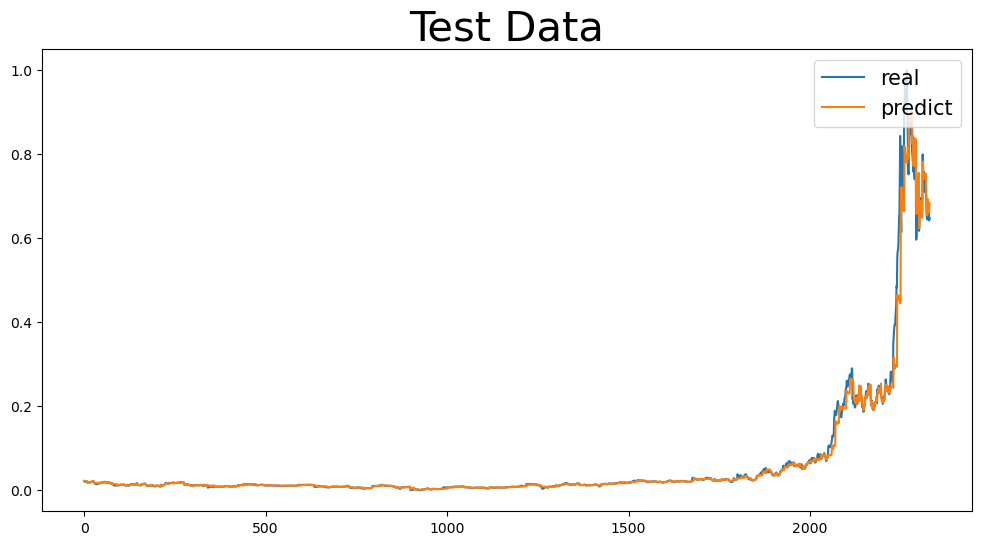

In [27]:
# 绘制实际值和预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='real')
plt.plot(predictions, label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Test Data", fontsize=30)
plt.show()

In [28]:
# 创建临时数组，只包含目标特征列
temp_pred = np.zeros((predictions.shape[0], len(features)))
temp_act = np.zeros((actuals.shape[0], len(features)))

# 将预测值和实际值放入临时数组的目标列中
temp_pred[:, features.index(target)] = predictions.flatten()
temp_act[:, features.index(target)] = actuals.flatten()

# 打印填充预测值和实际值后的临时数组
print(f'Temp pred array (first 5 rows):\n{temp_pred[:5]}')
print(f'Temp act array (first 5 rows):\n{temp_act[:5]}')

Temp pred array (first 5 rows):
[[0.         0.02224469 0.         0.         0.         0.        ]
 [0.         0.02223345 0.         0.         0.         0.        ]
 [0.         0.02203245 0.         0.         0.         0.        ]
 [0.         0.02078672 0.         0.         0.         0.        ]
 [0.         0.02080183 0.         0.         0.         0.        ]]
Temp act array (first 5 rows):
[[0.         0.02181194 0.         0.         0.         0.        ]
 [0.         0.02074939 0.         0.         0.         0.        ]
 [0.         0.0210299  0.         0.         0.         0.        ]
 [0.         0.02021387 0.         0.         0.         0.        ]
 [0.         0.02020537 0.         0.         0.         0.        ]]


In [29]:
# 进行逆归一化，只针对目标特征列
inverse_predictions = min_max_scaler.inverse_transform(temp_pred)[:, features.index(target)]
inverse_actuals = min_max_scaler.inverse_transform(temp_act)[:, features.index(target)]

# 打印逆归一化后的结果
print(f'Inverse predictions (first 10 values): {inverse_predictions[:10]}')
print(f'Inverse actuals (first 10 values): {inverse_actuals[:10]}')

Inverse predictions (first 10 values): [37.81909674 37.80587736 37.5694139  36.10391203 36.1216836  36.97264196
 37.23414726 37.27916212 37.01908086 35.52408428]
Inverse actuals (first 10 values): [37.31 36.06 36.39 35.43 35.42 36.67 37.16 36.64 35.36 33.32]


In [30]:
print(f'Shape of Inverse predictions: {inverse_predictions.shape}')
print(f'Shape of Inverse actuals: {inverse_actuals.shape}')

Shape of Inverse predictions: (2330,)
Shape of Inverse actuals: (2330,)


测试集上的MAE: 5.885718190896036
测试集上的MSE: 644.9971724096415
测试集上的MAPE: 4.252390149787463


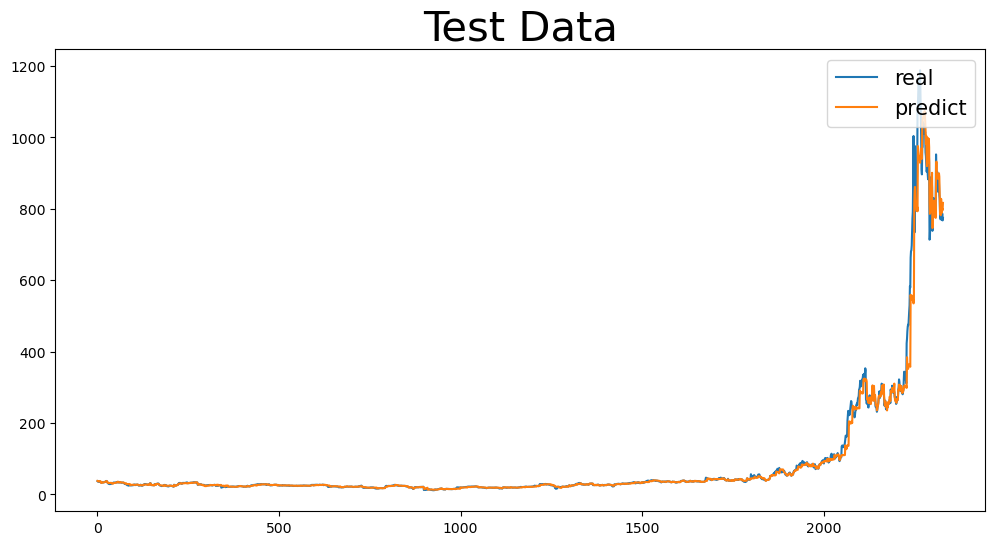

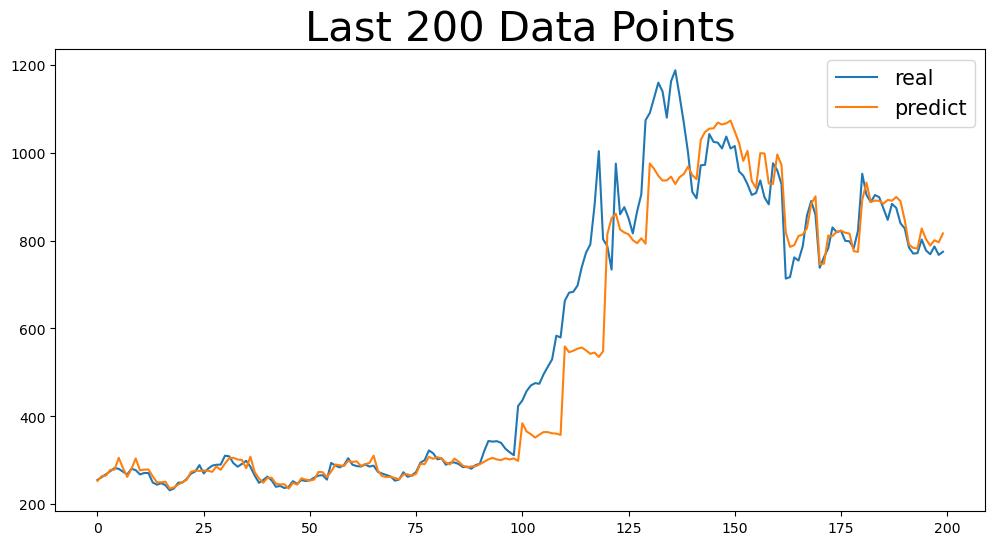

最后10个点的实际值: [827.94 784.51 770.59 771.61 802.52 777.92 769.11 786.86 767.61 774.74]
最后10个点的预测值: [846.94796795 791.22828925 783.5039701  782.05138977 827.82558271
 803.80720527 788.87572611 801.11391261 796.20692229 816.56409029]
最后10个点的RMSE: 22.701647207888076


In [31]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print('测试集上的MAE:', mean_absolute_error(inverse_predictions, inverse_actuals))
print('测试集上的MSE:', mean_squared_error(inverse_predictions, inverse_actuals))
print('测试集上的MAPE:', mape(inverse_predictions, inverse_actuals))

# 绘制实际值和预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(inverse_actuals, label='real')
plt.plot(inverse_predictions, label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Test Data", fontsize=30)
plt.show()

# 绘制最新200个点的实际值和预测值对比图
plt.figure(figsize=(12, 6))
plt.plot(inverse_actuals[-200:], label='real')
plt.plot(inverse_predictions[-200:], label='predict')
plt.legend(loc='upper right', fontsize=15)
plt.title("Last 200 Data Points", fontsize=30)
plt.show()

# 输出最后10个点的预测值和实际值
print('最后10个点的实际值:', inverse_actuals[-10:])
print('最后10个点的预测值:', inverse_predictions[-10:])

# 计算最后10个点的RMSE
rmse_last_10 = np.sqrt(mean_squared_error(inverse_actuals[-10:], inverse_predictions[-10:]))
print('最后10个点的RMSE:', rmse_last_10)
